In [1]:
# 2025年F1トップチームのセットアップ効率分析
# 分析テーマ：FP2・FP3でのアタック試行回数と予選順位の相関

import fastf1
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os

# キャッシュ設定
cache_folder = './cache'
if not os.path.exists(cache_folder):
    os.makedirs(cache_folder)
fastf1.Cache.enable_cache(cache_folder)

print("Analysis Theme: Setup Efficiency vs Qualifying Position")
print("=" * 60)

Analysis Theme: Setup Efficiency vs Qualifying Position


In [2]:
# 1. データ取得：FP2, FP3, Qualifyingの3セッション

def load_all_sessions(year, gp_name):
    """FP2, FP3, Qualifyingの全データを読み込む"""
    sessions = {}
    session_names = ['FP2', 'FP3', 'Qualifying']
    
    for session_name in session_names:
        try:
            print(f"Loading {session_name}...")
            session = fastf1.get_session(year, gp_name, session_name)
            session.load()
            
            if session_name == 'Qualifying':
                # 予選は特別な処理が必要な場合
                laps = session.laps.copy()
                results = session.results.copy()
                sessions[session_name] = {'laps': laps, 'results': results}
            else:
                sessions[session_name] = session.laps.copy()
            
            print(f"  {session_name}: {len(session.laps)} laps loaded")
            
        except Exception as e:
            print(f"  Error loading {session_name}: {e}")
            sessions[session_name] = None
    
    return sessions

# 全セッションデータを読み込み
all_sessions = load_all_sessions(2025, 'Abu Dhabi')

# データ確認
print("\nデータ読み込み結果:")
for session_name, data in all_sessions.items():
    if data is not None:
        if session_name == 'Qualifying':
            print(f"{session_name}: {len(data['laps'])} laps, {len(data['results'])} drivers")
        else:
            print(f"{session_name}: {len(data)} laps, {data['Driver'].nunique()} drivers")

Loading FP2...


core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 2 [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INF

  FP2: 584 laps loaded
Loading FP3...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

  FP3: 326 laps loaded
Loading Qualifying...


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to

  Qualifying: 286 laps loaded

データ読み込み結果:
FP2: 584 laps, 20 drivers
FP3: 326 laps, 20 drivers
Qualifying: 286 laps, 20 drivers


In [3]:
# 2. アタック回数の集計（X軸）

def count_attack_laps(fp_laps, session_name):
    """FPセッションでのアタックラップをカウント"""
    if fp_laps is None or fp_laps.empty:
        return pd.DataFrame()
    
    print(f"\nAnalyzing {session_name} attack laps...")
    
    # SOFTまたはMEDIUMタイヤのみを対象
    attack_laps_all = []
    
    for driver in fp_laps['Driver'].unique():
        driver_laps = fp_laps[fp_laps['Driver'] == driver].copy()
        
        # タイヤでフィルタ
        soft_medium_laps = driver_laps[
            driver_laps['Compound'].isin(['SOFT', 'MEDIUM'])
        ].copy()
        
        if soft_medium_laps.empty:
            continue
        
        # ドライバーのセッション自己ベストを計算
        valid_laps = soft_medium_laps[soft_medium_laps['LapTime'].notna()].copy()
        if valid_laps.empty:
            continue
            
        driver_best = valid_laps['LapTime'].min()
        threshold_107 = driver_best * 1.07
        
        # 107%以内のラップをアタックラップと判定
        attack_laps = valid_laps[
            valid_laps['LapTime'] <= threshold_107
        ].copy()
        
        # 異常に遅いラップを除外（アウトラップ・インラップの除去）
        if len(attack_laps) > 0:
            median_time = attack_laps['LapTime'].median()
            attack_laps = attack_laps[
                attack_laps['LapTime'] <= median_time * 1.2
            ]
        
        attack_laps_all.append({
            'Driver': driver,
            'Session': session_name,
            'AttackLaps': len(attack_laps),
            'BestLapTime': driver_best,
            'Threshold107': threshold_107
        })
    
    return pd.DataFrame(attack_laps_all)

# FP2とFP3のアタックラップを集計
fp2_attacks = count_attack_laps(all_sessions.get('FP2'), 'FP2')
fp3_attacks = count_attack_laps(all_sessions.get('FP3'), 'FP3')

# FP2とFP3を合計
if not fp2_attacks.empty and not fp3_attacks.empty:
    total_attacks = pd.merge(fp2_attacks, fp3_attacks, on='Driver', how='outer', suffixes=('_FP2', '_FP3'))
    total_attacks['AttackLaps_FP2'] = total_attacks['AttackLaps_FP2'].fillna(0)
    total_attacks['AttackLaps_FP3'] = total_attacks['AttackLaps_FP3'].fillna(0)
    total_attacks['TotalAttackLaps'] = total_attacks['AttackLaps_FP2'] + total_attacks['AttackLaps_FP3']
    
    print(f"\nTotal attack laps summary:")
    print(total_attacks[['Driver', 'AttackLaps_FP2', 'AttackLaps_FP3', 'TotalAttackLaps']].sort_values('TotalAttackLaps'))
else:
    print("No attack lap data available")
    total_attacks = pd.DataFrame()
    


Analyzing FP2 attack laps...

Analyzing FP3 attack laps...

Total attack laps summary:
   Driver  AttackLaps_FP2  AttackLaps_FP3  TotalAttackLaps
15    RUS               4               3                7
1     ALO               6               2                8
5     COL               2               6                8
9     HUL               5               4                9
2     ANT               7               3               10
18    TSU               7               3               10
11    LEC               6               5               11
8     HAM               9               2               11
0     ALB               7               4               11
3     BEA               6               5               11
19    VER               7               4               11
12    NOR               4               8               12
4     BOR               9               4               13
17    STR               8               5               13
10    LAW               9  

In [4]:
    # 3. 予選データの取得（Y軸）

def get_qualifying_results(qualifying_data):
    """予選結果から各ドライバーの順位を取得"""
    if qualifying_data is None:
        return pd.DataFrame()
    
    results = qualifying_data['results'].copy()
    
    # 必要なカラムを抽出
    qual_results = results[['DriverNumber', 'Abbreviation', 'TeamName', 'Position']].copy()
    qual_results['Position'] = pd.to_numeric(qual_results['Position'], errors='coerce')
    
    # ドライバーコードをキーとして使用
    qual_results = qual_results.rename(columns={'Abbreviation': 'Driver'})
    
    print(f"\nQualifying results:")
    print(qual_results[['Driver', 'TeamName', 'Position']].sort_values('Position'))
    
    return qual_results

# 予選結果を取得
qualifying_results = get_qualifying_results(all_sessions.get('Qualifying'))


Qualifying results:
   Driver         TeamName  Position
1     VER  Red Bull Racing       1.0
4     NOR          McLaren       2.0
81    PIA          McLaren       3.0
63    RUS         Mercedes       4.0
16    LEC          Ferrari       5.0
14    ALO     Aston Martin       6.0
5     BOR      Kick Sauber       7.0
31    OCO     Haas F1 Team       8.0
6     HAD     Racing Bulls       9.0
22    TSU  Red Bull Racing      10.0
87    BEA     Haas F1 Team      11.0
55    SAI         Williams      12.0
30    LAW     Racing Bulls      13.0
12    ANT         Mercedes      14.0
18    STR     Aston Martin      15.0
44    HAM          Ferrari      16.0
23    ALB         Williams      17.0
27    HUL      Kick Sauber      18.0
10    GAS           Alpine      19.0
43    COL           Alpine      20.0


In [5]:
# 4. 2025年シーズン年間ランキング（チーム内序列を考慮した期待順位）

def get_2025_standings():
    """2025年F1シーズンのドライバー・コンストラクターランキングを手動で設定"""
    
    # 2025年ドライバーズランキング（実際のデータ）
    drivers_data = {
        'Pos': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        'Driver': [
            'Lando Norris', 'Max Verstappen', 'Oscar Piastri', 'George Russell', 
            'Charles Leclerc', 'Lewis Hamilton', 'Kimi Antonelli', 'Alexander Albon',
            'Carlos Sainz', 'Fernando Alonso', 'Nico Hulkenberg', 'Isack Hadjar',
            'Oliver Bearman', 'Liam Lawson', 'Esteban Ocon', 'Lance Stroll',
            'Yuki Tsunoda', 'Pierre Gasly', 'Gabriel Bortoleto', 'Franco Colapinto'
        ],
        'Abbreviation': [
            'NOR', 'VER', 'PIA', 'RUS', 'LEC', 'HAM', 'ANT', 'ALB',
            'SAI', 'ALO', 'HUL', 'HAD', 'BEA', 'LAW', 'OCO', 'STR',
            'TSU', 'GAS', 'BOR', 'COL'
        ],
        'Team': [
            'McLaren', 'Red Bull Racing', 'McLaren', 'Mercedes',
            'Ferrari', 'Ferrari', 'Mercedes', 'Williams',
            'Williams', 'Aston Martin', 'Kick Sauber', 'Racing Bulls',
            'Haas F1 Team', 'Racing Bulls', 'Haas F1 Team', 'Aston Martin',
            'Red Bull Racing', 'Alpine', 'Kick Sauber', 'Alpine'
        ],
        'Points': [
            423, 421, 410, 319, 242, 156, 150, 73, 64, 56, 51, 51, 41, 38, 38, 33, 33, 22, 19, 0
        ]
    }
    
    drivers_df = pd.DataFrame(drivers_data)
    
    # チームごとの合計ポイントを計算
    team_points = drivers_df.groupby('Team')['Points'].sum().reset_index()
    team_points = team_points.sort_values('Points', ascending=False).reset_index(drop=True)
    team_points['TeamRank'] = team_points.index + 1
    
    print("=== チーム別合計ポイントとランキング ===")
    print(team_points.to_string(index=False))
    
    # 1. チーム内ランク（IntraTeamRank）の算出
    print("\n=== チーム内ランク算出 ===")
    drivers_df = drivers_df.sort_values(['Team', 'Points'], ascending=[True, False])
    drivers_df['IntraTeamRank'] = drivers_df.groupby('Team').cumcount() + 1
    
    # チーム内ランクの確認
    print("各チームのドライバー序列:")
    for team in sorted(drivers_df['Team'].unique()):
        team_drivers = drivers_df[drivers_df['Team'] == team]
        team_ranks = team_drivers[['Driver', 'Points', 'IntraTeamRank']].sort_values('IntraTeamRank')
        print(f"{team}: {team_ranks.to_string(index=False)}")
    
    # 2. チーム実力値（TeamPerformancePos）の計算
    # チーム情報をマージ
    drivers_df = pd.merge(drivers_df, team_points[['Team', 'TeamRank']], on='Team', how='left')
    
    # TeamPerformancePos = (TeamRank - 1) * 2 + IntraTeamRank
    drivers_df['TeamPerfPos'] = (drivers_df['TeamRank'] - 1) * 2 + drivers_df['IntraTeamRank']
    
    print(f"\n=== チーム実力値計算 ===")
    print("TeamPerformancePos = (TeamRank - 1) * 2 + IntraTeamRank")
    print("例: チーム1位の2番手 → (1-1)*2 + 2 = 2位相当")
    print("例: チーム3位の1番手 → (3-1)*2 + 1 = 5位相当")
    
    # 3. 最終的な期待順位（ExpectedPosition）の計算
    # ドライバー実力30% : マシン実力70%
    drivers_df['ExpectedPos'] = (drivers_df['Pos'] * 0.3) + (drivers_df['TeamPerfPos'] * 0.7)
    
    print(f"\n=== 最終期待順位計算 ===")
    print("ExpectedPosition = (DriverRank × 0.3) + (TeamPerformancePos × 0.7)")
    print("ドライバー実力: 30%、マシン実力（チーム内序列考慮）: 70%")
    
    return drivers_df, team_points

# 2025年シーズンランキングを取得
drivers_standings, team_rankings = get_2025_standings()

# ドライバーズランキング（新しい期待順位付き）を表示
print("\n" + "=" * 140)
print("2025 F1 DRIVERS CHAMPIONSHIP (TEAM-INTERNAL RANKING CONSIDERED)")
print("=" * 140)
display_columns = ['Driver', 'Team', 'Pos', 'TeamRank', 'IntraTeamRank', 'TeamPerfPos', 'ExpectedPos']
print(drivers_standings[display_columns].round(2).to_string(index=False))

# 計算過程の詳細を表示
print("\n" + "=" * 100)
print("CALCULATION PROCESS DETAILS")
print("=" * 100)
print("チーム内序列を考慮した期待順位計算の例:")
sample_teams = ['McLaren', 'Red Bull Racing', 'Ferrari', 'Mercedes']
for team in sample_teams:
    team_data = drivers_standings[drivers_standings['Team'] == team].sort_values('IntraTeamRank')
    print(f"\n{team}:")
    for _, row in team_data.iterrows():
        driver_rank = row['Pos']
        team_rank = row['TeamRank']
        intra_rank = row['IntraTeamRank']
        team_perf = row['TeamPerfPos']
        expected = row['ExpectedPos']
        
        print(f"  {row['Driver']}: ドライバー{driver_rank}位 × 0.3 + チーム実力{team_perf}位 × 0.7 = {expected:.2f}位")
        print(f"    (チーム{team_rank}位の{intra_rank}番手 → チーム実力{team_perf}位相当)")

# チーム実力値の分布を確認
print(f"\n" + "=" * 80)
print("TEAM PERFORMANCE POSITION DISTRIBUTION")
print("=" * 80)
team_perf_dist = drivers_standings.groupby('TeamPerfPos').size().reset_index(name='DriverCount')
print(team_perf_dist.to_string(index=False))

def get_team_colors():
    """F1チームのカラーコードを定義"""
    team_colors = {
        'Red Bull Racing': '#1E41FF',      # ブルー
        'McLaren': '#FF8700',              # オレンジ
        'Ferrari': '#DC0000',              # レッド
        'Mercedes': '#00D2BE',             # シアン
        'Alpine': '#0090FF',               # ブルー
        'Aston Martin': '#006F62',         # 緑
        'Williams': '#005AFF',              # ブルー
        'Racing Bulls': '#5E8FAA',         # ネイビー
        'Kick Sauber': '#52E252',          # 緑
        'Haas F1 Team': '#B6BABD'          # グレー
    }
    return team_colors

# チームカラーを取得
team_colors = get_team_colors()

print("\nTeam colors defined:")
for team, color in team_colors.items():
    print(f"  {team}: {color}")

=== チーム別合計ポイントとランキング ===
           Team  Points  TeamRank
        McLaren     833         1
       Mercedes     469         2
Red Bull Racing     454         3
        Ferrari     398         4
       Williams     137         5
   Aston Martin      89         6
   Racing Bulls      89         7
   Haas F1 Team      79         8
    Kick Sauber      70         9
         Alpine      22        10

=== チーム内ランク算出 ===
各チームのドライバー序列:
Alpine:           Driver  Points  IntraTeamRank
    Pierre Gasly      22              1
Franco Colapinto       0              2
Aston Martin:          Driver  Points  IntraTeamRank
Fernando Alonso      56              1
   Lance Stroll      33              2
Ferrari:          Driver  Points  IntraTeamRank
Charles Leclerc     242              1
 Lewis Hamilton     156              2
Haas F1 Team:         Driver  Points  IntraTeamRank
Oliver Bearman      41              1
  Esteban Ocon      38              2
Kick Sauber:            Driver  Points  IntraTeamRank
 

In [6]:
# 5. データ結合と最終集計（チーム内序列を考慮した期待順位）

# 全データを結合
if not total_attacks.empty and not qualifying_results.empty:
    # アタック回数と予選結果を結合
    final_data = pd.merge(total_attacks, qualifying_results, on='Driver', how='inner')
    
    print("マージ後のカラム確認:")
    print(final_data.columns.tolist())
    print(f"マージ後のデータ形状: {final_data.shape}")
    
    # チームカラーを追加
    final_data['TeamColor'] = final_data['TeamName'].map(team_colors)
    final_data['TeamColor'] = final_data['TeamColor'].fillna('#808080')  # デフォルト色
    
    # 新しい期待順位計算済みドライバーデータをマージ
    final_data = pd.merge(final_data, drivers_standings, left_on='Driver', right_on='Abbreviation', how='left', suffixes=('', '_season'))
    
    print("ドライバー成績マージ後のカラム確認:")
    print(final_data.columns.tolist())
    
    # 必要なカラムを抽出
    available_columns = [col for col in [
        'Driver', 'TeamName', 'TeamColor', 
        'AttackLaps_FP2', 'AttackLaps_FP3', 'TotalAttackLaps', 
        'Position', 'Pos', 'TeamRank', 'IntraTeamRank', 'TeamPerfPos', 'ExpectedPos'
    ] if col in final_data.columns]
    
    analysis_data = final_data[available_columns].copy()
    
    # カラム名を整理
    analysis_data = analysis_data.rename(columns={
        'Pos': 'SeasonPosition',
        'ExpectedPos': 'ExpectedPosition'
    })
    
    print(f"抽出したカラム: {analysis_data.columns.tolist()}")
    print(f"分析データ形状: {analysis_data.shape}")
    
    # チーム内序列を考慮した期待順位偏差を計算
    if 'ExpectedPosition' in analysis_data.columns:
        # 新しい期待順位偏差を計算
        analysis_data['PositionDeviation'] = analysis_data['Position'] - analysis_data['ExpectedPosition']
        
        print("\n最終分析データ（チーム内序列を考慮した期待順位）:")
        print(analysis_data.sort_values('Position'))
        
        # 元の相関係数
        correlation_original = analysis_data['TotalAttackLaps'].corr(analysis_data['Position'])
        print(f"\n元の相関係数（アタック回数 vs 予選順位）: {correlation_original:.3f}")
        
        # チーム内序列考慮後の相関係数
        correlation_adjusted = analysis_data['TotalAttackLaps'].corr(analysis_data['PositionDeviation'])
        print(f"補正後相関係数（アタック回数 vs 期待順位偏差）: {correlation_adjusted:.3f}")
        
        # 解釈
        def interpret_correlation(corr):
            if corr < -0.3:
                return "負の相関あり（仮説を支持）"
            elif corr > 0.3:
                return "正の相関あり（仮説と逆）"
            else:
                return "相関なし"
        
        print(f"元の解釈: {interpret_correlation(correlation_original)}")
        print(f"補正後解釈: {interpret_correlation(correlation_adjusted)}")
        
        # 新しい期待順位計算の詳細を表示
        print(f"\n=== チーム内序列を考慮した期待順位計算の詳細 ===")
        print("計算式: ExpectedPosition = (DriverRank × 0.3) + (TeamPerformancePos × 0.7)")
        print("TeamPerformancePos = (TeamRank - 1) * 2 + IntraTeamRank")
        
        sample_drivers = analysis_data.head(5)
        for _, row in sample_drivers.iterrows():
            driver_rank = row['SeasonPosition']
            team_rank = row['TeamRank']
            intra_rank = row['IntraTeamRank']
            team_perf = row['TeamPerfPos']
            expected = row['ExpectedPosition']
            actual = row['Position']
            deviation = row['PositionDeviation']
            
            print(f"{row['Driver']}: ドライバー{driver_rank}位 × 0.3 + チーム実力{team_perf}位 × 0.7 = 期待{expected:.2f}位")
            print(f"          (チーム{team_rank}位の{intra_rank}番手 → チーム実力{team_perf}位相当)")
            print(f"          実際{actual}位、偏差{deviation:+.2f}")
        
        # チーム内でのセットアップ効率比較
        print(f"\n=== チーム内でのセットアップ効率比較 ===")
        for team in sorted(analysis_data['TeamName'].unique()):
            team_data = analysis_data[analysis_data['TeamName'] == team]
            if len(team_data) > 1:
                print(f"\n{team}:")
                for _, row in team_data.iterrows():
                    efficiency = "高い" if row['TotalAttackLaps'] <= 10 else "中程度" if row['TotalAttackLaps'] <= 15 else "低い"
                    performance = "期待以上" if row['PositionDeviation'] < 0 else "期待以下" if row['PositionDeviation'] > 0 else "期待通り"
                    print(f"  {row['Driver']}: アタック{row['TotalAttackLaps']}回（効率: {efficiency}）→ "
                          f"予選{row['Position']}位（{performance}: {row['PositionDeviation']:+.2f}）")
        
        # チーム実力値とアタック回数の関係
        print(f"\n=== チーム実力値とセットアップ効率の関係 ===")
        team_perf_corr = analysis_data['TeamPerfPos'].corr(analysis_data['TotalAttackLaps'])
        print(f"チーム実力値 vs アタック回数の相関: {team_perf_corr:.3f}")
        
        if team_perf_corr < -0.3:
            print("→ チーム実力が高い（TeamPerfPosが低い）ほどアタック回数が少ない（仮説を支持）")
        elif team_perf_corr > 0.3:
            print("→ チーム実力が高いほどアタック回数が多い（仮説と逆）")
        else:
            print("→ チーム実力とアタック回数に明確な関係なし")
        
    else:
        print("ExpectedPositionカラムがありません")
        analysis_data = pd.DataFrame()
    
else:
    print("データ結合に失敗しました")
    analysis_data = pd.DataFrame()

マージ後のカラム確認:
['Driver', 'Session_FP2', 'AttackLaps_FP2', 'BestLapTime_FP2', 'Threshold107_FP2', 'Session_FP3', 'AttackLaps_FP3', 'BestLapTime_FP3', 'Threshold107_FP3', 'TotalAttackLaps', 'DriverNumber', 'TeamName', 'Position']
マージ後のデータ形状: (20, 13)
ドライバー成績マージ後のカラム確認:
['Driver', 'Session_FP2', 'AttackLaps_FP2', 'BestLapTime_FP2', 'Threshold107_FP2', 'Session_FP3', 'AttackLaps_FP3', 'BestLapTime_FP3', 'Threshold107_FP3', 'TotalAttackLaps', 'DriverNumber', 'TeamName', 'Position', 'TeamColor', 'Pos', 'Driver_season', 'Abbreviation', 'Team', 'Points', 'IntraTeamRank', 'TeamRank', 'TeamPerfPos', 'ExpectedPos']
抽出したカラム: ['Driver', 'TeamName', 'TeamColor', 'AttackLaps_FP2', 'AttackLaps_FP3', 'TotalAttackLaps', 'Position', 'SeasonPosition', 'TeamRank', 'IntraTeamRank', 'TeamPerfPos', 'ExpectedPosition']
分析データ形状: (20, 12)

最終分析データ（チーム内序列を考慮した期待順位）:
   Driver         TeamName TeamColor  AttackLaps_FP2  AttackLaps_FP3  \
19    VER  Red Bull Racing   #1E41FF               7               4   
12    N

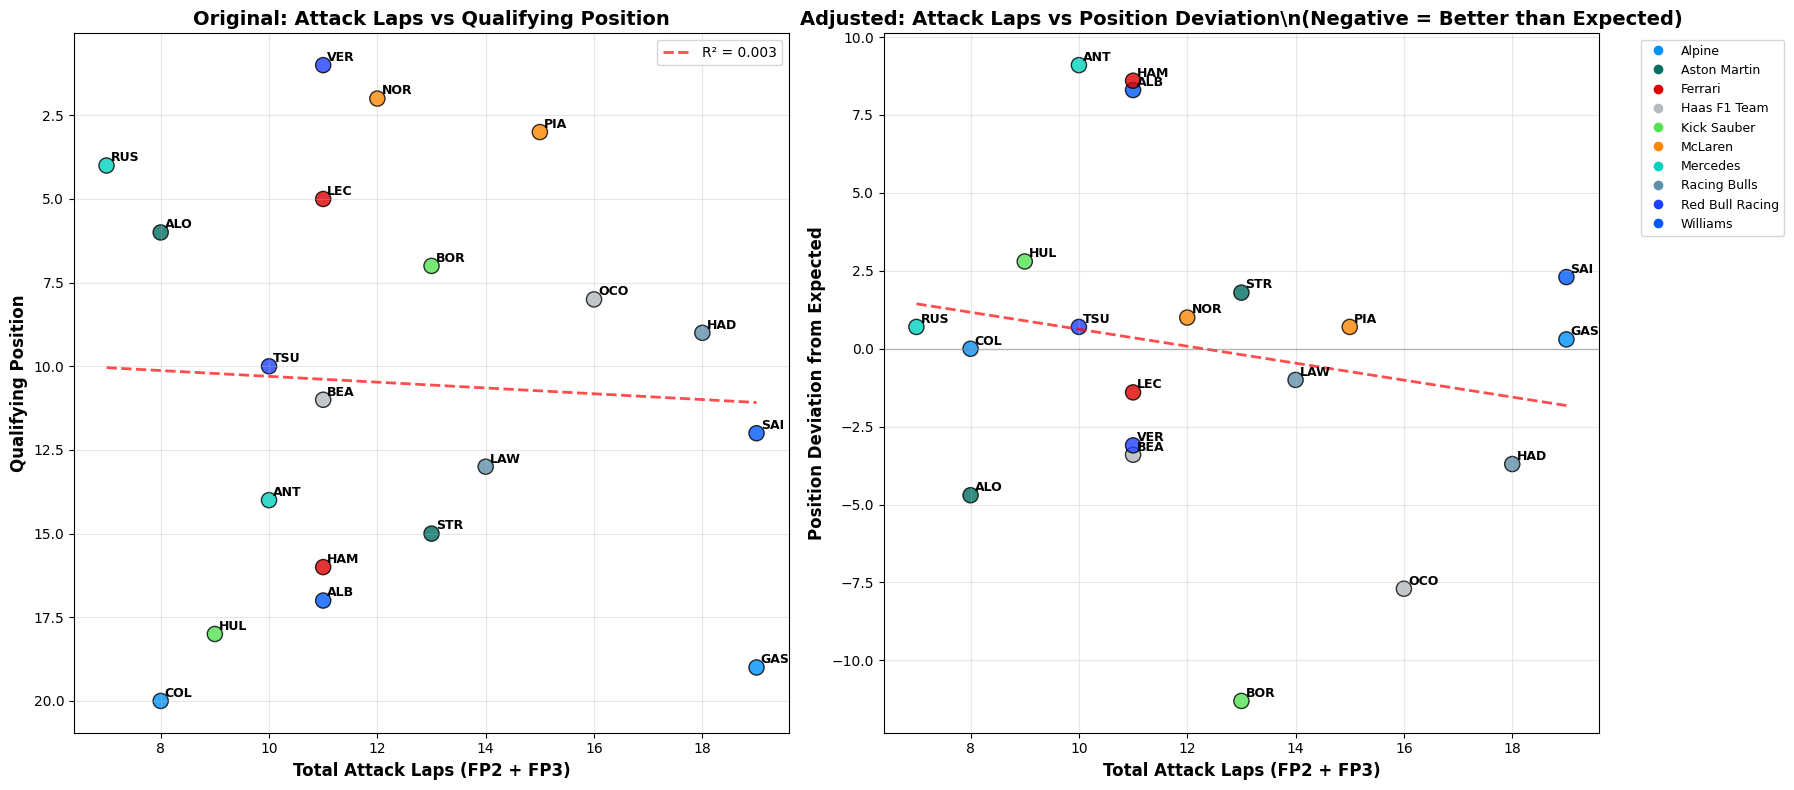

In [7]:
# 6. 可視化（元データと補正後データの比較）

if not analysis_data.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # 左側：元のデータ（アタック回数 vs 予選順位）
    scatter1 = ax1.scatter(
        analysis_data['TotalAttackLaps'], 
        analysis_data['Position'],
        c=analysis_data['TeamColor'],
        s=120, alpha=0.8, edgecolors='black', linewidth=1
    )
    
    # ドライバー名を表示
    for _, row in analysis_data.iterrows():
        ax1.annotate(
            row['Driver'], 
            (row['TotalAttackLaps'], row['Position']),
            xytext=(3, 3), textcoords='offset points',
            fontsize=9, fontweight='bold'
        )
    
    # 回帰直線を追加
    if len(analysis_data) > 2:
        x = analysis_data['TotalAttackLaps']
        y = analysis_data['Position']
        slope, intercept, r_value, _, _ = stats.linregress(x, y)
        line_x = np.linspace(x.min(), x.max(), 100)
        line_y = slope * line_x + intercept
        
        ax1.plot(line_x, line_y, 'r--', alpha=0.7, linewidth=2, 
                label=f'R² = {r_value**2:.3f}')
    
    ax1.set_xlabel('Total Attack Laps (FP2 + FP3)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Qualifying Position', fontsize=12, fontweight='bold')
    ax1.set_title('Original: Attack Laps vs Qualifying Position', 
                  fontsize=14, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    # 右側：補正後データ（アタック回数 vs 期待順位偏差）
    scatter2 = ax2.scatter(
        analysis_data['TotalAttackLaps'], 
        analysis_data['PositionDeviation'],
        c=analysis_data['TeamColor'],
        s=120, alpha=0.8, edgecolors='black', linewidth=1
    )
    
    # ドライバー名を表示
    for _, row in analysis_data.iterrows():
        ax2.annotate(
            row['Driver'], 
            (row['TotalAttackLaps'], row['PositionDeviation']),
            xytext=(3, 3), textcoords='offset points',
            fontsize=9, fontweight='bold'
        )
    
    # 回帰直線を追加
    if len(analysis_data) > 2:
        x = analysis_data['TotalAttackLaps']
        y = analysis_data['PositionDeviation']
        slope, intercept, r_value, _, _ = stats.linregress(x, y)
        line_x = np.linspace(x.min(), x.max(), 100)
        line_y = slope * line_x + intercept
        
        ax2.plot(line_x, line_y, 'r--', alpha=0.7, linewidth=2, 
                label=f'R² = {r_value**2:.3f}')
    
    # 0ラインを追加（期待通りに順位したドライバー）
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5, linewidth=1)
    
    ax2.set_xlabel('Total Attack Laps (FP2 + FP3)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Position Deviation from Expected', fontsize=12, fontweight='bold')
    ax2.set_title('Adjusted: Attack Laps vs Position Deviation\\n(Negative = Better than Expected)', 
                  fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    
    # チーム凡例を追加
    team_legend = []
    for team_name in sorted(analysis_data['TeamName'].unique()):
        team_data = analysis_data[analysis_data['TeamName'] == team_name]
        if not team_data.empty:
            color = team_data['TeamColor'].iloc[0]
            team_legend.append(plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor=color, markersize=8, label=team_name))
    
    ax2.legend(handles=team_legend, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("分析データがないためグラフを作成できません")

In [8]:
# 7. 仮説検証と結論（ドライバー性能補正付き）

if not analysis_data.empty:
    print("\n" + "=" * 80)
    print("仮説検証：セットアップ効率と予選順位の相関分析（ドライバー性能補正付き）")
    print("=" * 80)
    
    print("\n【仮説】")
    print("「FP2・FP3でのアタック試行回数が少ないドライバーほど、")
    print("セットアップが早期に決まっており、予選順位が高い」")
    print("（ドライバーのシーズン成績差を考慮して検証）")
    
    # 相関分析
    correlation_original = analysis_data['TotalAttackLaps'].corr(analysis_data['Position'])
    correlation_adjusted = analysis_data['TotalAttackLaps'].corr(analysis_data['PositionDeviation'])
    n_drivers = len(analysis_data)
    
    print(f"\n【分析結果】")
    print(f"対象ドライバー数: {n_drivers}名")
    print(f"元の相関係数: {correlation_original:.3f}")
    print(f"補正後相関係数: {correlation_adjusted:.3f}")
    
    # 有意性のチェック
    if len(analysis_data) > 2:
        x = analysis_data['TotalAttackLaps']
        y1 = analysis_data['Position']
        y2 = analysis_data['PositionDeviation']
        
        _, p_value_orig = stats.pearsonr(x, y1)
        _, p_value_adj = stats.pearsonr(x, y2)
        
        print(f"元のp値: {p_value_orig:.3f}")
        print(f"補正後p値: {p_value_adj:.3f}")
        
        def check_significance(p_val):
            return "統計的に有意" if p_val < 0.05 else "統計的に有意でない"
        
        print(f"元の有意性: {check_significance(p_value_orig)}")
        print(f"補正後有意性: {check_significance(p_value_adj)}")
    
    # 仮説の評価
    print(f"\n【仮説の評価】")
    
    def evaluate_hypothesis(corr, p_val, label):
        if corr < -0.3:
            if p_val < 0.05:
                return f"{label}: 仮説が強く支持された"
            else:
                return f"{label}: 仮説が支持されたが、統計的有意性は低い"
        elif corr < -0.1:
            return f"{label}: 仮説を部分的に支持する傾向がある"
        elif corr > 0.1:
            return f"{label}: 仮説と逆の傾向が見られる"
        else:
            return f"{label}: 仮説を支持する証拠は見られなかった"
    
    if len(analysis_data) > 2:
        print(evaluate_hypothesis(correlation_original, p_value_orig, "元の分析"))
        print(evaluate_hypothesis(correlation_adjusted, p_value_adj, "補正後分析"))
    
    # ドライバー別の特徴分析
    print(f"\n【ドライバー別の特徴】")
    for _, row in analysis_data.sort_values('SeasonPosition').iterrows():
        driver = row['Driver']
        team = row['TeamName']
        attacks = row['TotalAttackLaps']
        qual_pos = row['Position']
        season_pos = row['SeasonPosition']
        deviation = row['PositionDeviation']
        
        if attacks <= 10:
            efficiency = "高い"
        elif attacks <= 15:
            efficiency = "中程度"
        else:
            efficiency = "低い"
        
        performance = "期待以上" if deviation < 0 else "期待以下" if deviation > 0 else "期待通り"
        
        print(f"{driver} ({team}, シーズン{season_pos}位): アタック{attacks}回（効率: {efficiency}）→ "
              f"予選{qual_pos}位（{performance}: {deviation:+.1f}）")
    
    # ビジネスインパクト
    print(f"\n【ビジネスインパクト】")
    if correlation_adjusted < -0.3:
        print("✅ ドライバー能力を考慮してもセットアップ効率の影響が確認された")
        print("✅ ドライバー個人のセットアップ適応能力を評価できる")
        print("✅ シミュレーター精度と実戦セットアップの関連性が示唆された")
    elif correlation_original < -0.3 and correlation_adjusted > -0.1:
        print("⚠️ 相関は主にドライバー能力差によるもの可能性")
        print("⚠️ セットアップ効率の影響は限定的かもしれない")
        print("⚠️ より精密な補正モデルが必要")
    else:
        print("⚠️ このレースではセットアップ効率の影響は確認できなかった")
        print("⚠️ 全レースでの分析が必要")
        print("⚠️ 他の要因（天候、トラック条件等）の影響が大きい")
    
    print(f"\n【今後の展開】")
    print("1. 全レースでの傾向確認（シーズン全体での相関）")
    print("2. より精密なドライバー能力補正モデルの開発")
    print("3. 天候、トラック条件、タイヤ戦略との複合分析")
    print("4. チーム内でのドライバー比較分析")
    print("5. ピットストップ戦略シミュレーションへの応用")
    
else:
    print("分析データがないため仮説検証ができません")


仮説検証：セットアップ効率と予選順位の相関分析（ドライバー性能補正付き）

【仮説】
「FP2・FP3でのアタック試行回数が少ないドライバーほど、
セットアップが早期に決まっており、予選順位が高い」
（ドライバーのシーズン成績差を考慮して検証）

【分析結果】
対象ドライバー数: 20名
元の相関係数: 0.052
補正後相関係数: -0.191
元のp値: 0.827
補正後p値: 0.420
元の有意性: 統計的に有意でない
補正後有意性: 統計的に有意でない

【仮説の評価】
元の分析: 仮説を支持する証拠は見られなかった
補正後分析: 仮説を部分的に支持する傾向がある

【ドライバー別の特徴】
NOR (McLaren, シーズン1位): アタック12回（効率: 中程度）→ 予選2.0位（期待以下: +1.0）
VER (Red Bull Racing, シーズン2位): アタック11回（効率: 中程度）→ 予選1.0位（期待以上: -3.1）
PIA (McLaren, シーズン3位): アタック15回（効率: 中程度）→ 予選3.0位（期待以下: +0.7）
RUS (Mercedes, シーズン4位): アタック7回（効率: 高い）→ 予選4.0位（期待以下: +0.7）
LEC (Ferrari, シーズン5位): アタック11回（効率: 中程度）→ 予選5.0位（期待以上: -1.4）
HAM (Ferrari, シーズン6位): アタック11回（効率: 中程度）→ 予選16.0位（期待以下: +8.6）
ANT (Mercedes, シーズン7位): アタック10回（効率: 高い）→ 予選14.0位（期待以下: +9.1）
ALB (Williams, シーズン8位): アタック11回（効率: 中程度）→ 予選17.0位（期待以下: +8.3）
SAI (Williams, シーズン9位): アタック19回（効率: 低い）→ 予選12.0位（期待以下: +2.3）
ALO (Aston Martin, シーズン10位): アタック8回（効率: 高い）→ 予選6.0位（期待以上: -4.7）
HUL (Kick Sauber, シーズン11位): アタック9回（効率: 高い）→ 予選18.0位（期待以下: +2.8）
HAD (Racing Bu